In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
def factory(sigma_square):
    def get_kernel(x, e):
        sigma = np.sqrt(sigma_square)
        mu = np.log(e) - sigma_square / 2
        result = (
                np.divide(1, x, where=x != 0)
                * sigma * np.sqrt(2 * np.pi)
                * np.exp(
            - ((np.log(x, where=x != 0) - mu) ** 2
               / (2 * sigma ** 2))
        )
        )
        result[0] = 0
        result_sum = np.sum(result)
        if result_sum != 0:
            result /= result_sum
        return result

    def convolve(target, kernel):
        return np.convolve(target, kernel)[:len(target)]

    def get_expectation(x, y):
        return np.dot(x, y)

    return get_kernel, convolve, get_expectation

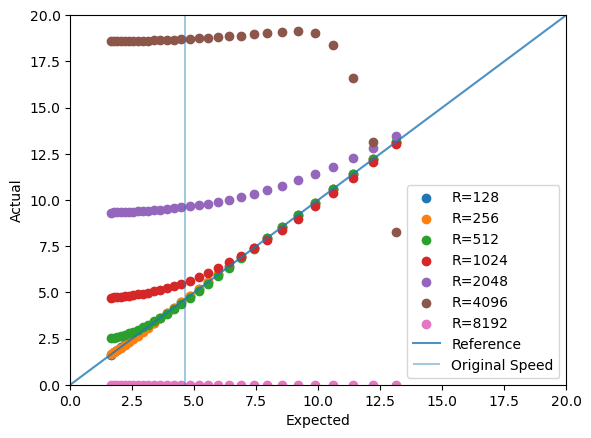

In [4]:
resolution_list = [128, 256, 512, 1024, 2048, 4096, 8192]
base_distance = 1024 / 44100
distance_list = base_distance * np.logspace(-1.5, 1.5, 30, base=2)
conv_num = 200
score_duration = 20

get_kernel, convolve, get_expectation = factory(0.3)  # this is fixed
for resolution in resolution_list:
    actual_axis = []
    ref_axis = []
    for distance in distance_list:
        time_axis = np.arange(0, score_duration, resolution / 44100)
        kernel = get_kernel(time_axis, distance)
        pdf_axis = np.zeros(len(time_axis))
        pdf_axis[0] = 1.0
        for _ in range(conv_num):
            pdf_axis = convolve(pdf_axis, kernel)
        actual = get_expectation(time_axis, pdf_axis)
        ref = distance * conv_num
        actual_axis.append(actual)
        ref_axis.append(ref)
    plt.scatter(ref_axis, actual_axis, label=f'R={resolution:d}')
plt.plot([0, score_duration], [0, score_duration], alpha=0.8, label='Reference')
plt.vlines(base_distance * conv_num, 0, score_duration, alpha=0.4, label='Original Speed')
plt.xlim([0, score_duration])
plt.ylim([0, score_duration])
plt.xlabel('Expected')
plt.ylabel('Actual')
plt.legend()
plt.show()